# Conditional DCGAN - Ising model

In [3]:
%matplotlib inline

# basic libraries
import os, sys
import re
import copy
import glob
from itertools import product
import pickle
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, Lambda, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

In [4]:
# local library
sys.path.append('../../force_fields/statmechlib')
from statmechlib.read_write import read_lattice_ising
from statmechlib.preprocessing import Trajectory

## Load data from MC simulations

In [5]:
sim_dir = '../src/mcsim/mini'
temps = ['t1', 't2', 't5', 't10', 't20', 't100']  # ferromagnetic
temps.extend(['a1', 'a2', 'a5', 'a10', 'a20', 'a100'])  # antiferromagnetic

In [ ]:
trjs = {}
for t in temps:
    #print(t)
    traj = read_lattice_ising(os.path.join(sim_dir, t))
    trjs[t] = Trajectory(traj)
    trjs[t] = trjs[t][1:]

print(trjs.keys())
print(len(trjs['t1']['energy']))

In [ ]:
cfgs = {}
cfgs_pad = {}
for key, trj in trjs.items():
    cfgs[key] = []
    cfgs_pad[key] = []
    for t_cfg, xyz_cfg in zip(trj['atom_type'], trj['xyz_latt']): 
        cfg = np.empty((15, 15), dtype=float)
        for t, (i, j, k) in zip(t_cfg, xyz_cfg):
            cfg[i-1, j-1] = 0.5*(t+1)
        cfgs[key].append(cfg)
        cfgs_pad[key].append(np.pad(cfg, pad_width=((1,1), (1,1)), mode='wrap'))

## Examples of configurations for ferromagnetic (t) and antiferromagnetic (a) Ising models at different reduced temperatures (1 - 100)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(25,10))
axs = axs.flatten()
for i, t in enumerate(temps):
    axs[i].set_title(t, fontsize=30)
    axs[i].matshow(cfgs[t][200])

fig.tight_layout()

In [ ]:
# Input image dimensions
img_rows, img_cols = cfgs['t1'][0].shape
channels = 1
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 9

print('Input image shape: ', img_shape)
print('Feature space dimension: ', z_dim)

## Generator

In [28]:
def sample(x):
    prediction = 0.5*(K.sign(x*2 -1) + 1)
    return prediction    

In [34]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 3x3 tensor via a fully connected layer
    model.add(Dense(1 * 3 * 3, input_dim=z_dim))
    model.add(Reshape((3, 3, 1)))

    # Transposed convolution layer, from 3x3x1 into 7x7x8 tensor
    model.add(Conv2DTranspose(8, kernel_size=3, strides=2, padding='valid'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='valid'))

    # Output layer with sigmoid activation giving the probability of particle presence
    model.add(Activation('sigmoid'))
    #model.add(Lambda(sample))

    return model

In [35]:
# def build_cgan_generator(z_dim):

#     # Random noise vector z
#     z = Input(shape=(z_dim, ))

#     # Conditioning label: integer 0-9 specifying the number G should generate
#     label = Input(shape=(1, ), dtype='int32')

#     # Label embedding:
#     # ----------------
#     # Turns labels into dense vectors of size z_dim
#     # Produces 3D tensor with shape (batch_size, 1, z_dim)
#     label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)

#     # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, z_dim)
#     label_embedding = Flatten()(label_embedding)

#     # Element-wise product of the vectors z and the label embeddings
#     joined_representation = Multiply()([z, label_embedding])

#     generator = build_generator(z_dim)

#     # Generate image for the given label
#     conditioned_img = generator(joined_representation)

#     return Model([z, label], conditioned_img)

## Discriminator

In [1]:
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 15x15x1 into 7x7x8 tensor
    model.add(Conv2D(8, kernel_size=3, strides=2, input_shape=img_shape, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    # Convolutional layer, from 7x7x8 into 3x3x1 tensor
    model.add(Conv2D(1, kernel_size=3, strides=2, input_shape=img_shape, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    # Output layer with sigmoid activation
    model.add(Flatten())
    #model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(9, activation='softmax'))
    model.add(Lambda(lambda x: x**0.5))

    return model

## Full GAN

In [37]:
def build_gan(generator, discriminator):
    """Combined Generator -> Discriminator model"""

    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

## Build/compile the models

In [38]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy'])
#discriminator.compile(loss='cosine_proximity', optimizer=Adam())#, #metrics=['accuracy'])

# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='mean_squared_error', optimizer=Adam())
#gan.compile(loss='cosine_proximity', optimizer=Adam())

In [39]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 9)                 90        
_________________________________________________________________
reshape_2 (Reshape)          (None, 3, 3, 1)           0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 7, 7, 8)           80        
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 8)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 8)           32        
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 15, 15, 1)         73        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 15, 1)         0         
Total para

In [40]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 7, 7, 8)           80        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 8)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 8)           32        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 1)           73        
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 3, 3, 1)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 1)           4         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9)                 0         
__________

/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [41]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 15, 15, 1)         275       
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 199       
Total params: 474
Trainable params: 259
Non-trainable params: 215
_________________________________________________________________


## Training

In [48]:
def sample_images(generator, image_grid_rows=2, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    #gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(8, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

    plt.show()

In [49]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(target_data, iterations, batch_size, sample_interval):

    X_train = target_data
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real and fake images: all ones and zeros, respectively
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images (Multinomial approx. by Normal)
        z = np.random.normal(0, 1, (batch_size, 9))
        
        gen_imgs = generator.predict(z)

        # ---------------------
        # Train Discriminator
        # ---------------------

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 9))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration, d_loss, 100.0 * accuracy, g_loss))
            print(np.sum(gen_imgs[5]))
            print(gen_imgs[0,0,:].flatten())
            print(imgs[0,0,:].flatten())

            # Output a sample of generated image
            sample_images(generator)

## Train the Model and Inspect Output

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

In [50]:
target_data = np.array(cfgs['a1'][:])
target_data.shape

(1000, 15, 15)

0 [D loss: 0.696747, acc.: 41.41%] [G loss: 0.674858]
177.28262
[0.81583625 0.80501366 0.841103   0.8338017  0.77257794 0.8597796
 0.7252803  0.8227959  0.7682117  0.7811054  0.82057554 0.83062726
 0.7694218  0.8317319  0.748937  ]
[0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


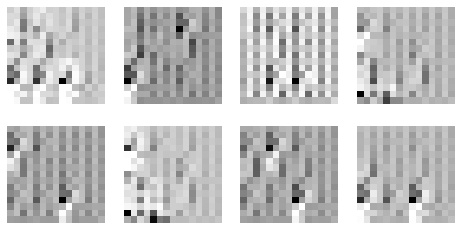

200 [D loss: 0.671515, acc.: 51.56%] [G loss: 0.728050]
183.159
[0.8286397  0.86328554 0.8223312  0.86352116 0.8296032  0.8600791
 0.83633524 0.86069334 0.8179963  0.8680205  0.81006175 0.8635226
 0.81851184 0.86488056 0.76617706]
[1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


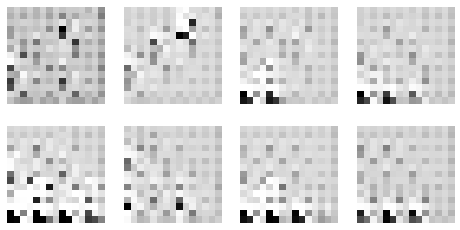

400 [D loss: 0.684859, acc.: 59.38%] [G loss: 0.706871]
182.09598
[0.7785387  0.8280403  0.74462664 0.8236784  0.72873914 0.83905107
 0.7074006  0.82851005 0.72674584 0.8334232  0.71609116 0.8322027
 0.7280833  0.82727075 0.7258229 ]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]


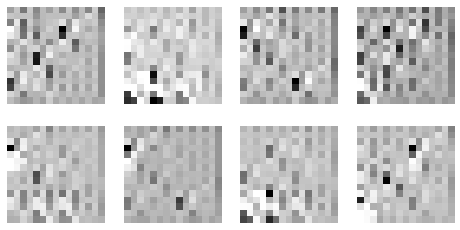

600 [D loss: 0.701566, acc.: 39.06%] [G loss: 0.667357]
176.74509
[0.7756662  0.7483415  0.77869564 0.7703285  0.8013092  0.7169611
 0.81653047 0.74372935 0.7867636  0.76378316 0.78240454 0.75139254
 0.7911249  0.75091755 0.7838995 ]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]


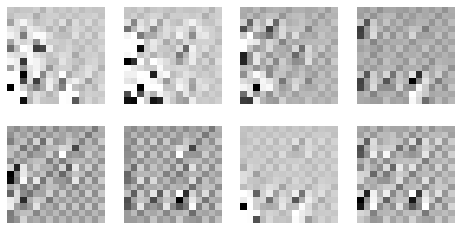

800 [D loss: 0.696766, acc.: 54.69%] [G loss: 0.684704]
179.00894
[0.7799859  0.7493241  0.81483316 0.7363534  0.80101806 0.7657048
 0.8013651  0.74032795 0.81081903 0.7496755  0.80625737 0.7479453
 0.8187332  0.731911   0.80992556]
[0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


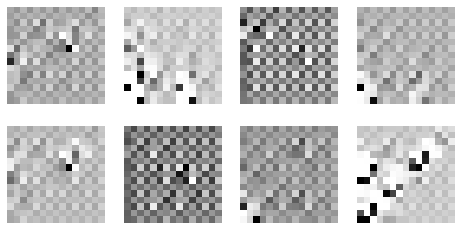

1000 [D loss: 0.694196, acc.: 48.44%] [G loss: 0.693123]
179.79262
[0.79012406 0.73244077 0.81065285 0.7522089  0.8296377  0.70684683
 0.8307726  0.7442145  0.81944823 0.7298835  0.8169497  0.7456848
 0.8190669  0.7291393  0.8120191 ]
[1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


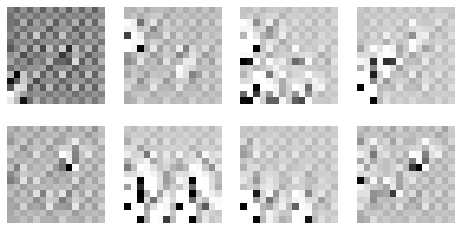

1200 [D loss: 0.685838, acc.: 63.28%] [G loss: 0.706359]
180.02287
[0.7816332  0.76364917 0.83705115 0.71473265 0.801859   0.8006887
 0.77926624 0.7640346  0.80848956 0.7577947  0.8470959  0.7021602
 0.797893   0.8125645  0.7674202 ]
[0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


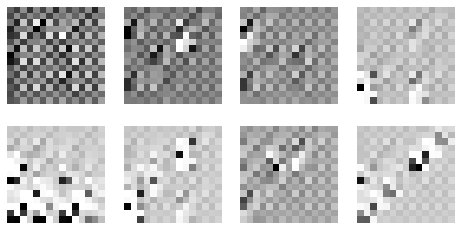

1400 [D loss: 0.702015, acc.: 50.78%] [G loss: 0.751255]
186.8559
[0.8391051  0.8284382  0.8156654  0.84717286 0.81284577 0.8291664
 0.8266618  0.8385639  0.81746227 0.83547795 0.82752365 0.83123296
 0.8274098  0.83585954 0.7900657 ]
[0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1.]


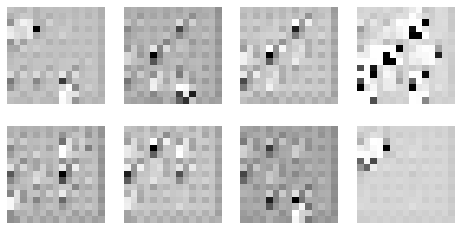

1600 [D loss: 0.659897, acc.: 64.84%] [G loss: 0.854722]
188.9899
[0.8387687  0.8730852  0.81362224 0.8655298  0.81192756 0.8803775
 0.8085568  0.85704273 0.83277506 0.8713256  0.80360365 0.8791797
 0.8035968  0.86499554 0.8039694 ]
[0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1.]


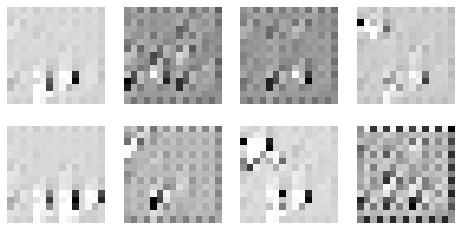

1800 [D loss: 0.681807, acc.: 53.12%] [G loss: 0.770388]
191.38739
[0.8447857  0.8401168  0.8526211  0.85510993 0.82673734 0.85896504
 0.8208779  0.8466109  0.8431066  0.84791464 0.84052175 0.85139287
 0.8345859  0.85057664 0.83933234]
[0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


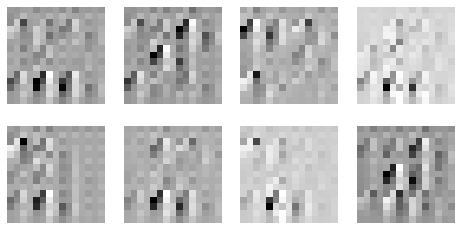

2000 [D loss: 0.727426, acc.: 43.75%] [G loss: 0.691662]
189.0487
[0.8654699  0.8455162  0.8682341  0.85458046 0.8704457  0.8277636
 0.88552785 0.8583635  0.85121465 0.85489714 0.8474508  0.868826
 0.82450944 0.87017846 0.811822  ]
[0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1.]


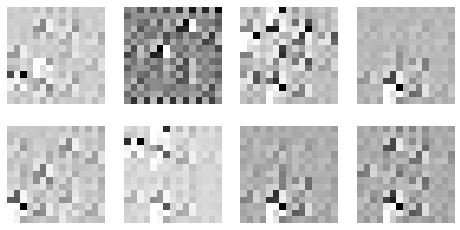

2200 [D loss: 0.692192, acc.: 47.66%] [G loss: 0.686015]
179.87427
[0.8533064  0.7123721  0.920774   0.7791198  0.89342535 0.6602241
 0.9444668  0.7790879  0.88994044 0.8506346  0.83090717 0.82239884
 0.79644257 0.82350993 0.805609  ]
[0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1.]


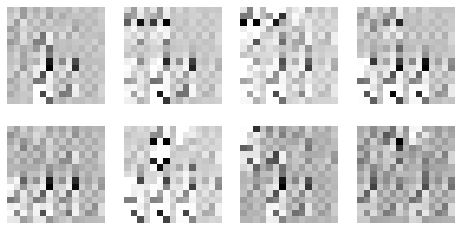

2400 [D loss: 0.660707, acc.: 61.72%] [G loss: 0.727582]
188.46547
[0.8198852  0.79984164 0.8173983  0.80483127 0.8090341  0.80379623
 0.8106778  0.8043041  0.9437662  0.9807618  0.7459288  0.843937
 0.7201545  0.80325305 0.8235627 ]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0.]


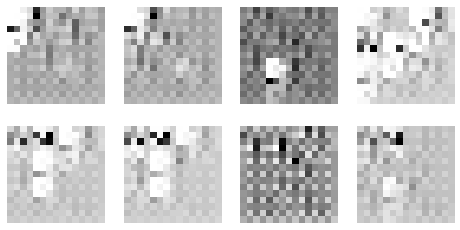

2600 [D loss: 0.698086, acc.: 48.44%] [G loss: 0.745737]
182.83325
[0.8460813  0.70424485 0.93117    0.71607924 0.9105614  0.83466935
 0.7849126  0.8147709  0.839908   0.7200429  0.9209366  0.7381134
 0.901647   0.8000859  0.8414265 ]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]


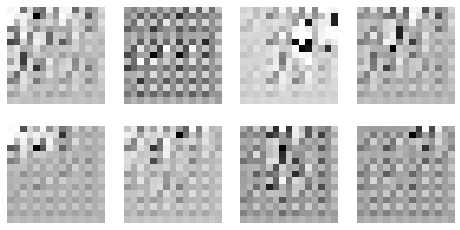

2800 [D loss: 0.667002, acc.: 63.28%] [G loss: 0.699768]
177.91519
[0.8421903  0.89387774 0.7589413  0.92573357 0.6032587  0.85111225
 0.8168867  0.8954148  0.7016972  0.84340787 0.81576717 0.8700254
 0.7547491  0.83087295 0.8120211 ]
[1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


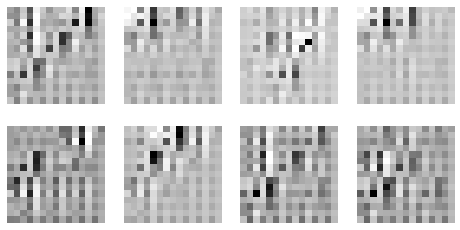

3000 [D loss: 0.686650, acc.: 57.81%] [G loss: 0.697549]
186.68991
[0.82199204 0.838126   0.823692   0.8272049  0.8330511  0.81220424
 0.82925636 0.7417184  0.9201103  0.85940987 0.81900525 0.885648
 0.7392571  0.84401274 0.80603075]
[0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


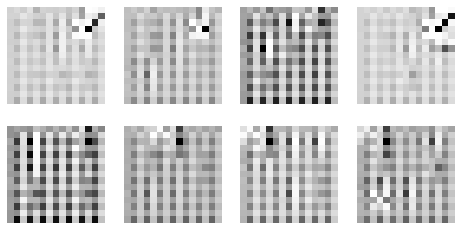

3200 [D loss: 0.687461, acc.: 51.56%] [G loss: 0.709018]
186.12686
[0.8464867  0.90387726 0.7349977  0.92454046 0.6420501  0.8958178
 0.75785077 0.92689663 0.5662859  0.7799766  0.86294454 0.7822944
 0.8748929  0.8416487  0.8033292 ]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.]


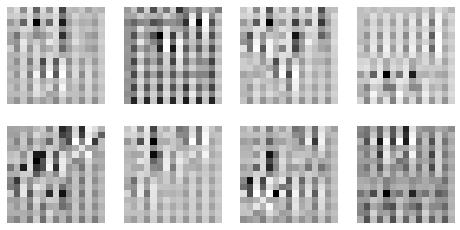

3400 [D loss: 0.662512, acc.: 59.38%] [G loss: 0.783359]
187.57057
[0.8570516  0.83365697 0.87330407 0.83316445 0.9356008  0.96183366
 0.8253065  0.8958262  0.9528361  0.9840019  0.8406913  0.89933604
 0.80555576 0.7440473  0.8956151 ]
[1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


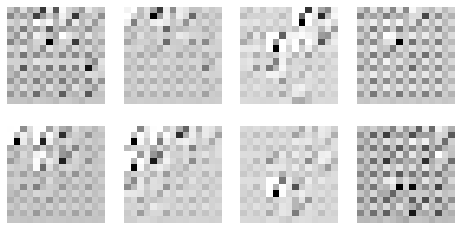

3600 [D loss: 0.697926, acc.: 44.53%] [G loss: 0.695863]
186.72083
[0.85277414 0.8082043  0.7918125  0.8093449  0.7850678  0.81024265
 0.8085611  0.8098914  0.73054266 0.81233    0.80796605 0.81112283
 0.8241228  0.80977935 0.80217177]
[1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.]


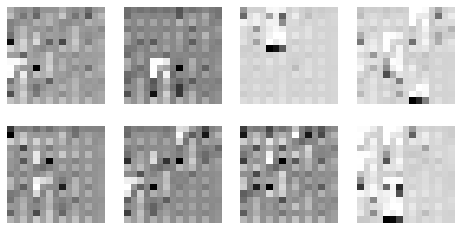

3800 [D loss: 0.697519, acc.: 49.22%] [G loss: 0.666602]
191.93996
[0.95307153 0.92819893 0.9413798  0.8942696  0.88182825 0.87342393
 0.90680254 0.8856862  0.87997913 0.8740896  0.8933433  0.8804577
 0.8991597  0.8817962  0.8591703 ]
[1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.]


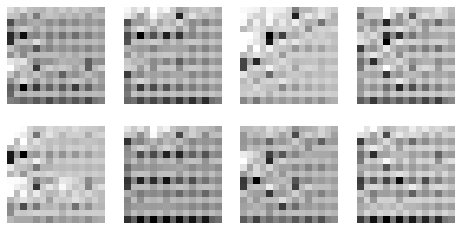

4000 [D loss: 0.503551, acc.: 80.47%] [G loss: 1.123076]
170.97424
[0.8251329  0.8153624  0.8171705  0.79250205 0.76778364 0.7722681
 0.78057295 0.7956781  0.9051356  0.9175686  0.8447389  0.813974
 0.62342644 0.6491225  0.7083209 ]
[0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


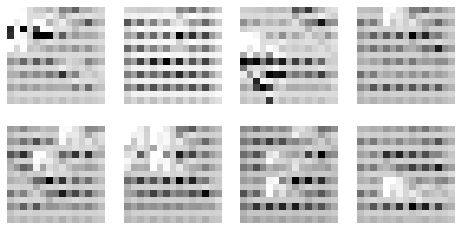

4200 [D loss: 0.627041, acc.: 64.84%] [G loss: 0.760593]
174.05557
[0.79145247 0.7992254  0.87729454 0.8393707  0.7201487  0.9515473
 0.78048354 0.8197458  0.25345814 0.9999752  0.8742265  0.7499279
 0.9872979  0.9999114  0.91263455]
[0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


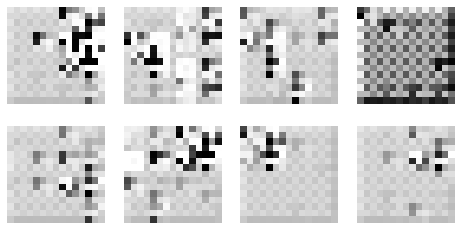

4400 [D loss: 0.688605, acc.: 56.25%] [G loss: 0.761153]
155.61533
[0.7845188  0.7307239  0.7727065  0.7307239  0.7727065  0.7307239
 0.7727065  0.7307239  0.6463627  0.6397693  0.72831416 0.7307239
 0.81825405 0.85617346 0.77416223]
[0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


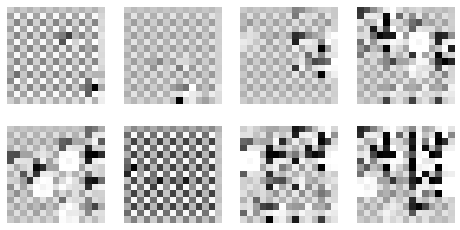

4600 [D loss: 0.674604, acc.: 55.47%] [G loss: 0.756475]
180.02657
[0.01955306 0.02566272 0.9811988  0.7312186  0.3875073  0.99997425
 0.24317907 0.81960714 0.84354043 0.81960714 0.84354043 0.81960714
 0.52136964 0.53960735 0.69379485]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.]


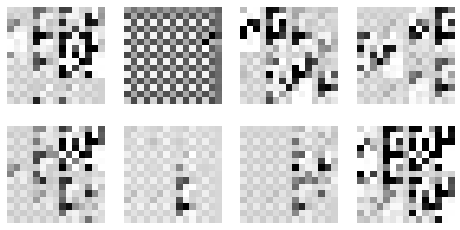

4800 [D loss: 0.693043, acc.: 50.78%] [G loss: 0.737234]
185.31955
[0.03996683 0.08582844 0.96263707 0.8531787  0.8662473  0.9985448
 0.7318587  0.8531787  0.8406766  0.8531787  0.8406766  0.8531787
 0.40405372 0.5449163  0.6632708 ]
[0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


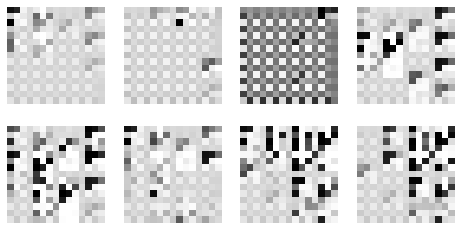

5000 [D loss: 0.596779, acc.: 65.62%] [G loss: 0.963879]
184.14174
[0.7941071  0.8195765  0.8545871  0.84476876 0.82492626 0.84476876
 0.82492626 0.84476876 0.83020645 0.8921036  0.84225416 0.84476876
 0.10806464 0.21994568 0.4884695 ]
[0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1.]


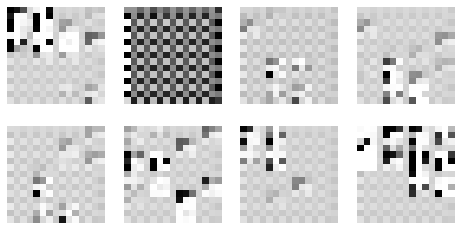

5200 [D loss: 0.623862, acc.: 71.09%] [G loss: 0.828558]
171.18826
[0.7583429  0.76036114 0.78281164 0.76036114 0.7976676  0.8008315
 0.7837509  0.76036114 0.93204796 0.9908535  0.7965076  0.76036114
 0.78281164 0.76036114 0.8496435 ]
[1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0.]


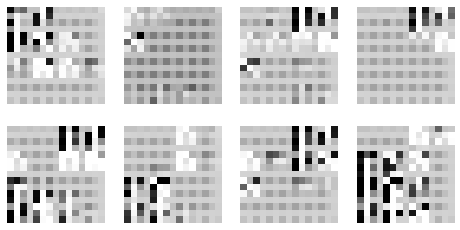

5400 [D loss: 0.726189, acc.: 39.84%] [G loss: 0.631640]
183.9657
[0.23430502 0.6320461  0.87225074 0.7967581  0.6742269  0.9985214
 0.01411954 0.7967581  0.8513392  0.7967581  0.8513392  0.7967581
 0.6796892  0.547207   0.8319286 ]
[0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1.]


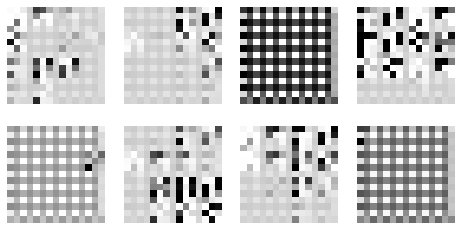

5600 [D loss: 0.687279, acc.: 49.22%] [G loss: 0.698811]
181.74509
[0.9413617  0.9990483  0.9419904  0.79410905 0.9051176  0.9710787
 0.89664865 0.79410905 0.9766058  0.9999567  0.9661112  0.79410905
 0.05095611 0.01827119 0.60013306]
[1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


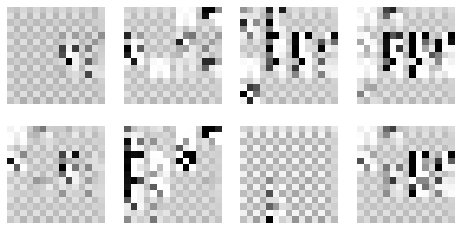

5800 [D loss: 0.581376, acc.: 75.78%] [G loss: 0.828501]
161.15503
[0.7758599  0.7964149  0.7983538  0.7964149  0.7983538  0.7964149
 0.7983538  0.7964149  0.952587   0.9998115  0.98418695 0.7964149
 0.3413957  0.24036583 0.57218486]
[1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0.]


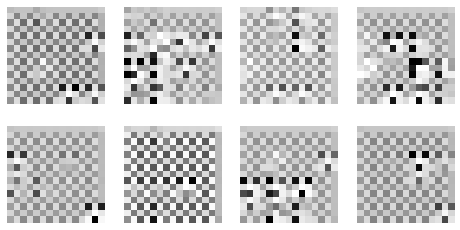

6000 [D loss: 0.673344, acc.: 56.25%] [G loss: 0.667000]
170.38672
[0.75015175 0.7792162  0.797389   0.7792162  0.797389   0.7792162
 0.797389   0.7792162  0.797389   0.7792162  0.797389   0.7792162
 0.797389   0.7792162  0.8357798 ]
[1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0.]


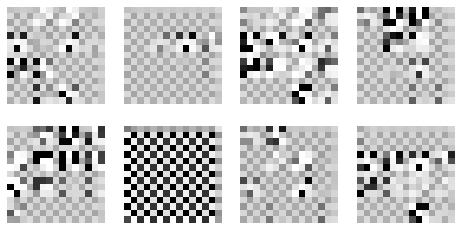

6200 [D loss: 0.664415, acc.: 56.25%] [G loss: 0.783790]
176.48148
[0.82788396 0.80247986 0.85575855 0.80247986 0.85268354 0.83551323
 0.8633197  0.80247986 0.6590601  0.99999034 0.99029255 0.80247986
 0.7515925  0.6615805  0.74342746]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.]


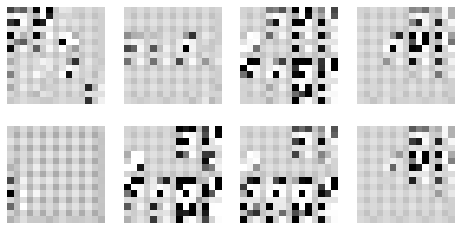

6400 [D loss: 0.688896, acc.: 56.25%] [G loss: 0.698148]
183.58275
[0.82849157 0.8401906  0.8131314  0.8401906  0.8131314  0.8401906
 0.8131314  0.8401906  0.8131314  0.8401906  0.8131314  0.8401906
 0.64850956 0.81150126 0.846651  ]
[1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0.]


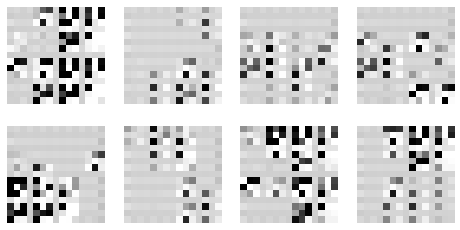

6600 [D loss: 0.661848, acc.: 59.38%] [G loss: 0.740512]
169.34924
[0.7598346  0.80294055 0.6763462  0.80052096 0.6017956  0.7963174
 0.7458397  0.80294055 0.7622325  0.9989195  0.88082063 0.80294055
 0.7216191  0.80294055 0.7553393 ]
[1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


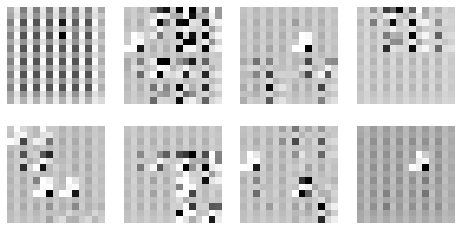

6800 [D loss: 0.655377, acc.: 67.19%] [G loss: 0.803201]
173.95078
[0.76706004 0.7821899  0.81774855 0.77872455 0.25544438 0.80908173
 0.8107538  0.7767331  0.76077896 0.78342295 0.84644026 0.7760636
 0.8594021  0.7754442  0.77007425]
[0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.]


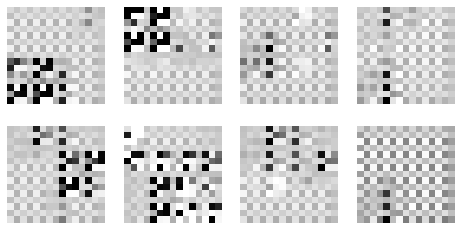

7000 [D loss: 0.674780, acc.: 62.50%] [G loss: 0.782847]
168.36597
[0.72863287 0.78744626 0.74248177 0.7867614  0.47150236 0.77151
 0.8487862  0.7947325  0.89925086 0.9364285  0.9298477  0.8001699
 0.8927737  0.8001699  0.7658784 ]
[0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1.]


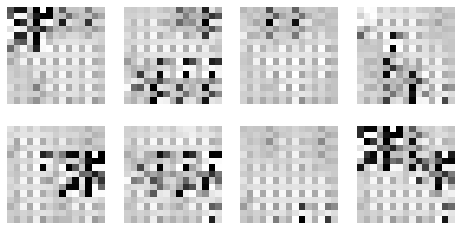

7200 [D loss: 0.615738, acc.: 72.66%] [G loss: 0.806688]
152.7141
[0.58599913 0.6480989  0.657537   0.65193796 0.06935333 0.7778483
 0.89990145 0.6726691  0.93156296 0.7498429  0.5368159  0.6777725
 0.9378104  0.755919   0.5107136 ]
[0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


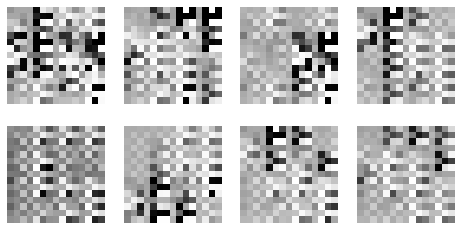

7400 [D loss: 0.641269, acc.: 65.62%] [G loss: 0.823985]
134.20827
[0.602715   0.9764372  0.9630576  0.81512177 0.74280727 0.81512177
 0.74280727 0.81512177 0.74280727 0.81512177 0.74280727 0.81512177
 0.74280727 0.81512177 0.25432304]
[1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0.]


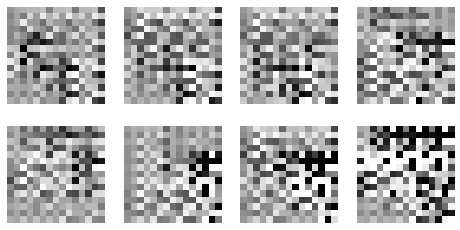

7600 [D loss: 0.554889, acc.: 79.69%] [G loss: 0.930146]
120.27988
[0.6571647  0.51298606 0.75597453 0.54224896 0.6078674  0.54224896
 0.5386765  0.53340995 0.65655977 0.54224896 0.28102022 0.49912107
 0.5020412  0.49686727 0.5612387 ]
[0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1.]


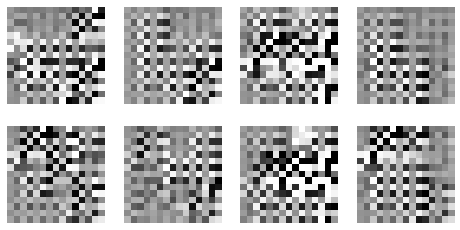

7800 [D loss: 0.709315, acc.: 55.47%] [G loss: 0.740324]
111.131744
[0.5495074  0.47825095 0.5756957  0.4904174  0.46400267 0.49417973
 0.33441854 0.48281527 0.48873782 0.48621708 0.5131977  0.49417973
 0.42050996 0.49417973 0.32019636]
[0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.]


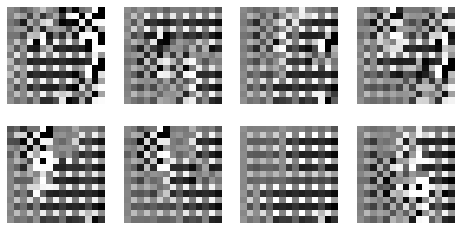

8000 [D loss: 0.639514, acc.: 65.62%] [G loss: 0.805469]
102.59114
[0.46950567 0.41225535 0.44215974 0.4133554  0.4521132  0.41464382
 0.42973405 0.4213858  0.36443618 0.6767478  0.5328516  0.42554286
 0.57777977 0.83736855 0.7441809 ]
[1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


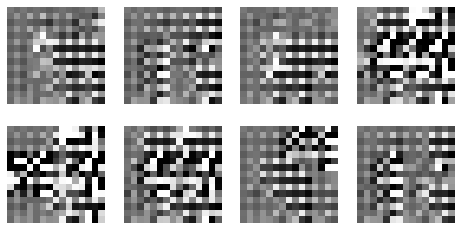

8200 [D loss: 0.594543, acc.: 68.75%] [G loss: 0.917834]
108.52626
[0.4529977  0.49077007 0.40953678 0.4850375  0.29948848 0.46153438
 0.7354924  0.50019103 0.6147881  0.5250914  0.36498928 0.51781446
 0.90437204 0.59789187 0.01940211]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0.]


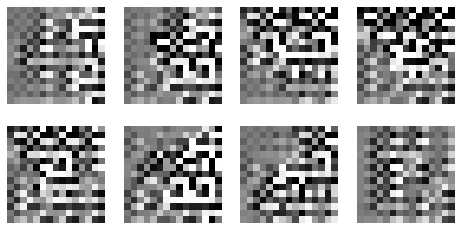

8400 [D loss: 0.718175, acc.: 56.25%] [G loss: 0.715413]
117.71144
[0.32494387 0.504367   0.664654   0.5173077  0.76337487 0.53465015
 0.37562972 0.51962125 0.4325442  0.40711462 0.19129221 0.52143425
 0.24373129 0.49975872 0.7466828 ]
[0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.]


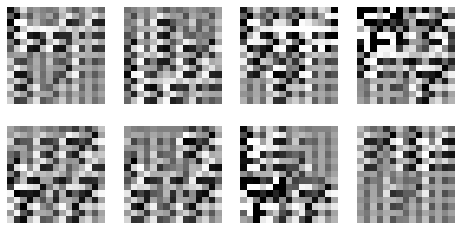

8600 [D loss: 0.676340, acc.: 60.94%] [G loss: 0.771709]
110.60564
[6.4130914e-01 5.7706696e-01 5.0091147e-01 5.8306545e-01 6.6724563e-01
 5.7264960e-01 4.3786058e-01 5.8472902e-01 1.3724483e-03 1.0000000e+00
 9.9999440e-01 5.5737221e-01 4.1648832e-01 8.1076509e-01 4.9098227e-05]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.]


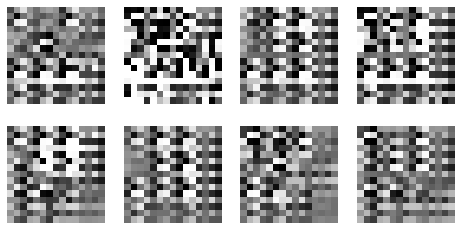

8800 [D loss: 0.584509, acc.: 68.75%] [G loss: 0.939824]
114.42082
[1.0508346e-01 1.2694739e-01 2.3619211e-04 3.5920882e-01 2.2662308e-03
 9.9954045e-01 3.7718191e-06 2.4980518e-01 2.4877391e-09 9.9999917e-01
 6.9172317e-18 5.1955557e-03 3.2799499e-11 1.0000000e+00 1.5278865e-11]
[1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0.]


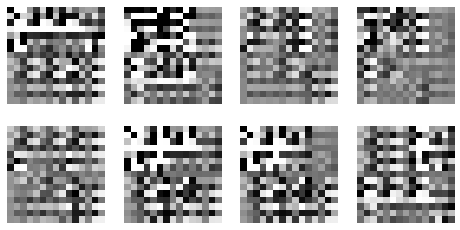

9000 [D loss: 0.679800, acc.: 55.47%] [G loss: 0.733755]
129.20282
[5.59202313e-01 5.15821159e-01 7.32826650e-01 5.14263868e-01
 8.73648643e-01 4.87126857e-01 3.97805631e-01 5.27779996e-01
 3.44172448e-01 1.24344334e-01 3.82382277e-05 1.49396658e-01
 4.69763501e-04 9.99993920e-01 6.87083483e-01]
[0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.]


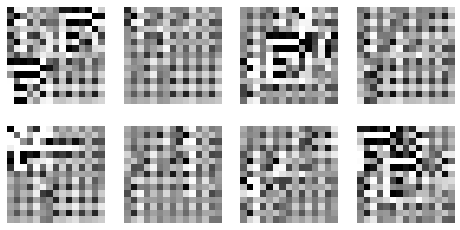

9200 [D loss: 0.674435, acc.: 74.22%] [G loss: 0.819319]
125.53907
[0.53361654 0.764192   0.4763746  0.7742414  0.2625595  0.8012055
 0.77539533 0.75433785 0.01150567 0.9999969  0.819601   0.7296498
 0.7646364  0.5384197  0.02925209]
[0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


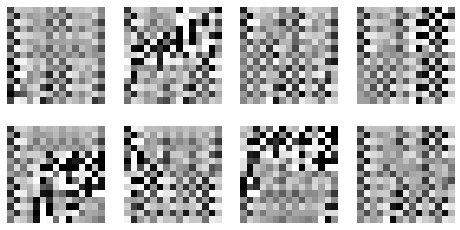

9400 [D loss: 0.536693, acc.: 78.91%] [G loss: 1.127540]
120.40833
[0.3720429  0.58035666 0.4492451  0.50429165 0.5852443  0.4424012
 0.45182946 0.499708   0.60294557 0.35143012 0.5838422  0.4424012
 0.5837569  0.4171111  0.37342685]
[1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


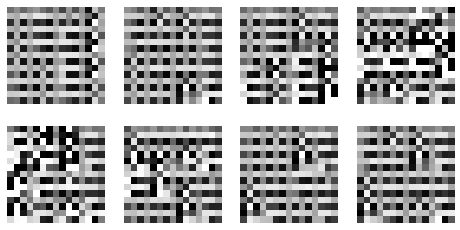

9600 [D loss: 0.474296, acc.: 79.69%] [G loss: 1.400113]
69.20186
[0.3176323  0.20317279 0.04736047 0.22829528 0.00083911 0.5492976
 0.01289804 0.22918169 0.00126333 0.51242256 0.01425145 0.23070563
 0.00352493 0.8199995  0.03088726]
[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0.]


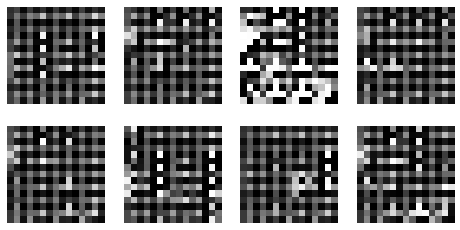

In [ ]:
# Set hyperparameters
iterations = 20001
batch_size = 64
sample_interval = 200

# Train the CGAN for the specified number of iterations
train(target_data, iterations, batch_size, sample_interval)

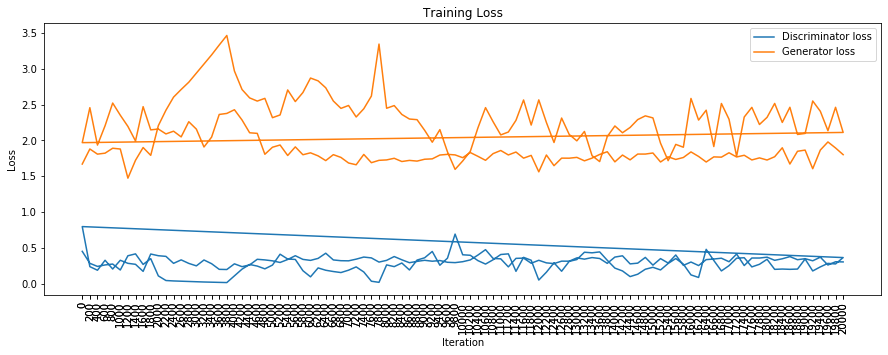

In [361]:
losses_x = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses_x.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses_x.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

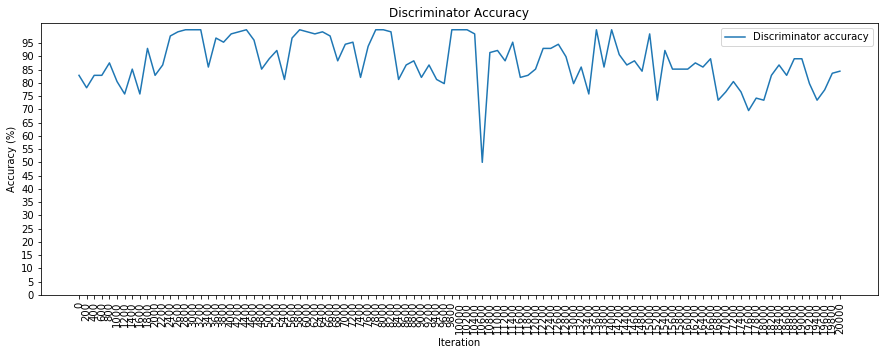

In [345]:
accuracies_x = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies_x, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

## Visualize filters

In [365]:
layer_name = 'conv2d_43'
filter_index = 0

layer_output = discriminator.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [366]:
discriminator.get_input_at(1)

<tf.Tensor 'sequential_58/activation_22/Sigmoid:0' shape=(?, ?, ?, 1) dtype=float32>

In [367]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, discriminator.get_input_at(0))[0]

In [368]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [369]:
iterate = K.function([discriminator.get_input_at(0)], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 15, 15, 1))])

In [370]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 15, 15, 1))

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

In [371]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [372]:
def generate_pattern(layer_name, filter_index, size=15):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = discriminator.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, discriminator.get_input_at(0))[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([discriminator.get_input_at(0)], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 1))

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return img #deprocess_image(img)

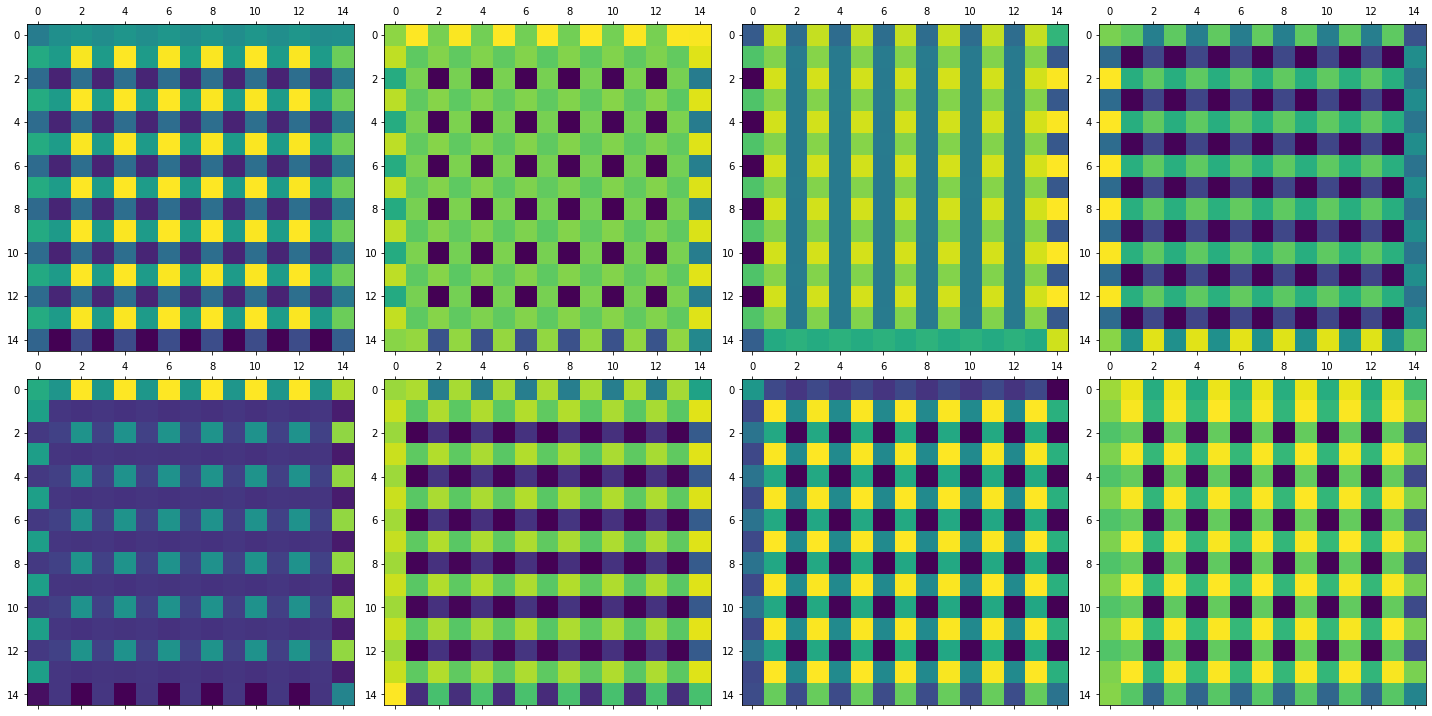

In [373]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = axs.flatten()
for i in range(8):
    axs[i].matshow(generate_pattern('conv2d_43', i)[:,:,0])

fig.tight_layout()

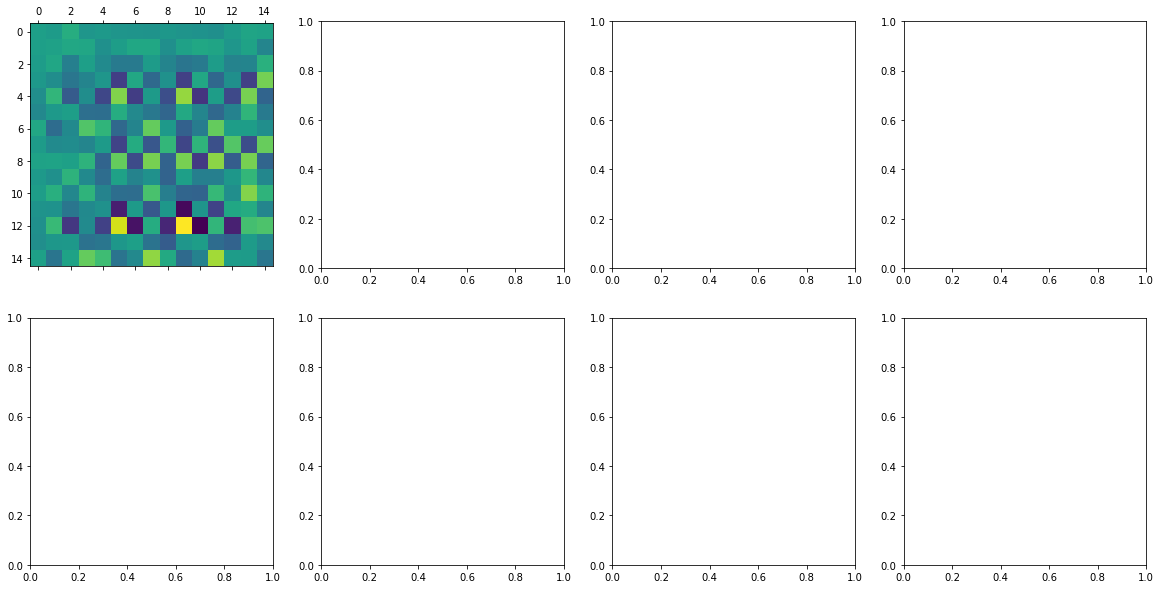

In [374]:
xfig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = axs.flatten()
for i in range(1):
    axs[i].matshow(generate_pattern('conv2d_44', i, size=15)[:,:,0])

fig.tight_layout()

In [342]:
target_data = np.array(cfgs['t2'][-768:])
target_data.shape

(768, 15, 15)

0 [D loss: 0.452058, acc.: 81.25%] [G loss: 1.670281]
112.96371
[6.7647089e-17 1.0000000e+00 1.3040328e-05 6.7200977e-04 4.9392962e-27
 1.0000000e+00 1.1377362e-21 5.9301255e-04 4.5742694e-22 1.0000000e+00
 1.4548741e-16 9.7112992e-05 4.7595230e-09 4.2283401e-01 8.2621781e-08]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
200 [D loss: 0.285016, acc.: 90.62%] [G loss: 1.880598]
112.05393
[9.8707759e-01 1.3248435e-05 9.9630260e-01 4.4498927e-04 1.0000000e+00
 1.8584441e-11 6.2827436e-15 9.9941826e-01 1.6784995e-08 7.4366731e-08
 9.8619139e-01 7.3339214e-04 9.9695587e-01 3.5713729e-05 9.9511212e-01]
[1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
400 [D loss: 0.241794, acc.: 89.84%] [G loss: 1.808769]
116.93167
[2.8208694e-10 9.9989414e-01 7.3538482e-01 1.1189361e-09 1.0000000e+00
 3.2430131e-10 8.8867246e-08 9.9985838e-01 1.8482411e-16 9.9997485e-01
 9.9996638e-01 2.0922679e-08 9.9791723e-01 2.6781810e-03 8.5479589e-03]
[1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]
600 [D loss: 0.262261

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


4200 [D loss: 0.203670, acc.: 93.75%] [G loss: 2.710618]
121.365814
[1.6417761e-12 1.0000000e+00 7.4752113e-16 1.0000000e+00 1.1658770e-21
 1.0000000e+00 1.3619364e-28 1.0000000e+00 3.6950879e-20 1.0000000e+00
 6.5829924e-18 1.0000000e+00 5.6305649e-05 1.0000000e+00 3.8752583e-04]
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
4400 [D loss: 0.268753, acc.: 92.19%] [G loss: 2.593673]
119.38223
[2.4471983e-05 9.9953747e-01 1.6726399e-05 9.9998796e-01 9.9379247e-01
 8.7743634e-01 9.9555463e-01 9.5881736e-01 1.3626089e-10 1.7890381e-02
 2.3108823e-05 1.0000000e+00 1.7873114e-09 1.0000000e+00 5.0819153e-08]
[0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
4600 [D loss: 0.246434, acc.: 90.62%] [G loss: 2.549371]
123.65082
[3.7576064e-11 1.0000000e+00 2.5244279e-14 1.0000000e+00 1.7156462e-10
 9.9999988e-01 9.8635441e-01 9.6807307e-01 9.8548935e-06 1.2233185e-10
 5.6494353e-12 9.9989557e-01 4.3030680e-14 4.8685947e-12 7.0583136e-12]
[0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
4800 [D loss: 0

9200 [D loss: 0.450452, acc.: 78.91%] [G loss: 1.975132]
112.90873
[4.7013757e-01 2.0452391e-03 9.9586833e-01 2.4991862e-03 9.9997997e-01
 7.5450507e-10 9.9999940e-01 1.7992942e-08 1.3488918e-04 9.7157896e-01
 3.7907869e-10 1.0000000e+00 5.4665647e-15 1.0000000e+00 2.8261461e-22]
[0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1.]
9400 [D loss: 0.258412, acc.: 89.84%] [G loss: 2.150702]
109.217575
[3.7669054e-06 9.9997437e-01 1.1177505e-05 1.0000000e+00 1.3447114e-10
 1.0000000e+00 6.0703789e-15 9.9649823e-01 7.4314755e-07 1.0000000e+00
 8.8344061e-11 1.0000000e+00 1.8746638e-06 1.0000000e+00 2.8349473e-10]
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.]
9600 [D loss: 0.357032, acc.: 82.03%] [G loss: 1.840095]
108.046646
[1.8779347e-03 4.5222241e-01 9.3433446e-01 1.0000000e+00 8.7691444e-07
 9.9999917e-01 3.5779962e-08 2.5253071e-08 5.2791848e-03 2.8287561e-04
 4.6356527e-07 9.9998736e-01 1.6534147e-03 9.9876803e-01 9.6726336e-04]
[1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
9800 [D loss: 

14200 [D loss: 0.178533, acc.: 94.53%] [G loss: 2.107237]
105.895294
[8.8239455e-01 9.9999821e-01 9.9999988e-01 6.7188358e-01 1.0000000e+00
 1.0000000e+00 5.0326274e-11 7.2652262e-01 0.0000000e+00 1.0000000e+00
 0.0000000e+00 8.9396060e-01 3.3501888e-19 9.9999154e-01 2.1279946e-12]
[1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0.]
14400 [D loss: 0.099646, acc.: 97.66%] [G loss: 2.181324]
115.6787
[8.4141415e-01 9.4813293e-01 1.0000000e+00 9.9443734e-01 1.0000000e+00
 1.0000000e+00 1.0000000e+00 9.5928425e-01 1.5815785e-05 9.9704725e-01
 1.3834630e-13 9.9901545e-01 1.8398928e-14 9.9995542e-01 8.5549312e-10]
[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
14600 [D loss: 0.132644, acc.: 97.66%] [G loss: 2.290827]
127.36677
[1.08266884e-16 9.54860006e-04 0.00000000e+00 9.99905825e-01
 0.00000000e+00 1.00000000e+00 0.00000000e+00 9.99773920e-01
 2.57168615e-21 1.00000000e+00 9.87684488e-01 9.61836278e-01
 9.99999762e-01 1.00000000e+00 9.99999523e-01]
[1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0

19200 [D loss: 0.178326, acc.: 92.97%] [G loss: 2.550647]
62.2554
[3.6181334e-02 2.1774402e-02 2.1730715e-05 1.9694759e-05 7.9739645e-02
 9.9999988e-01 9.9893850e-01 3.1231939e-09 1.8463000e-03 9.9091619e-01
 7.6681448e-12 6.8697195e-09 3.5434241e-25 4.4098913e-12 4.3902833e-21]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.]
19400 [D loss: 0.235032, acc.: 89.84%] [G loss: 2.407107]
110.491684
[1.18007533e-20 8.51535078e-05 0.00000000e+00 2.41732120e-11
 6.24895155e-13 1.19811695e-04 9.99999166e-01 3.54680640e-13
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.52870064e-10
 1.00000000e+00 1.00000000e+00 1.00000000e+00]
[1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
19600 [D loss: 0.284239, acc.: 91.41%] [G loss: 2.136278]
70.624664
[7.80001301e-06 1.05297231e-05 1.51398176e-12 1.54738646e-05
 5.70291156e-14 1.27416479e-06 1.33583813e-14 1.30647995e-05
 7.20800161e-01 1.00000000e+00 1.00000000e+00 2.30147793e-11
 1.00000000e+00 1.00000000e+00 9.99997258e-01]
[1. 1. 1. 1. 0. 1. 1. 1. 0. 1

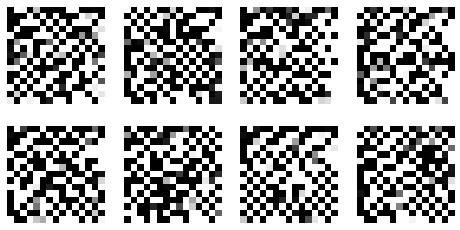

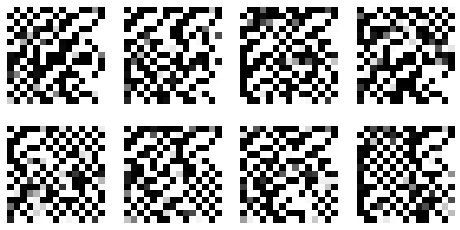

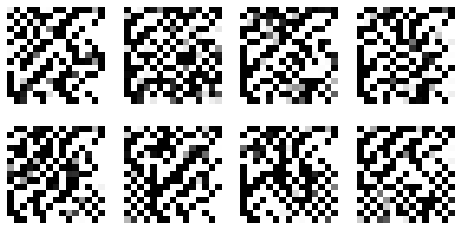

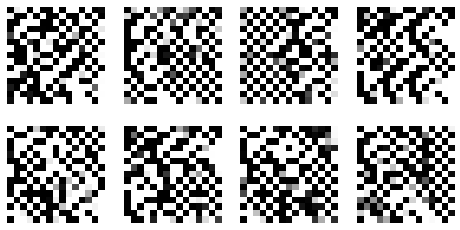

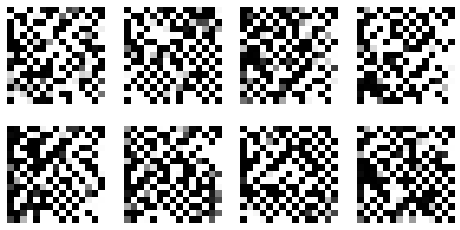

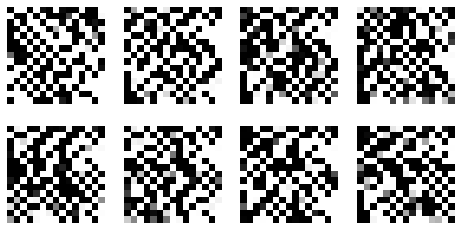

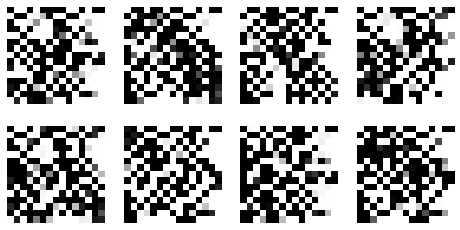

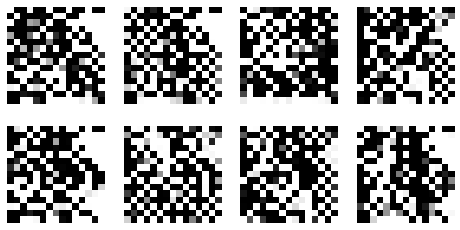

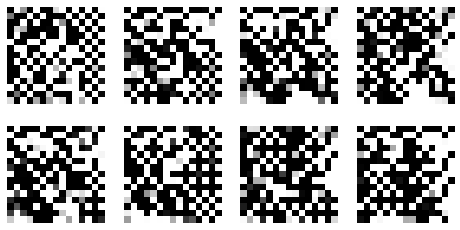

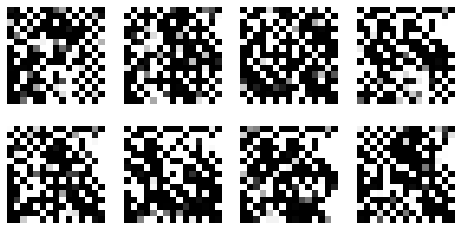

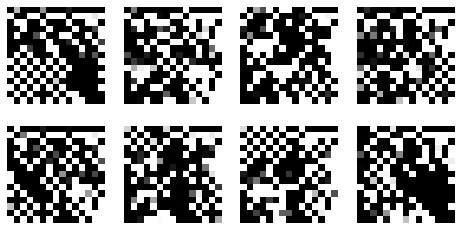

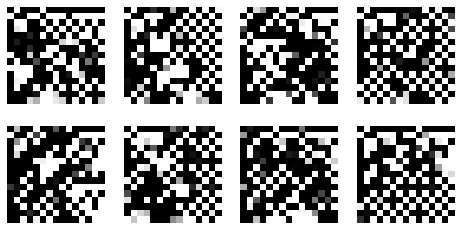

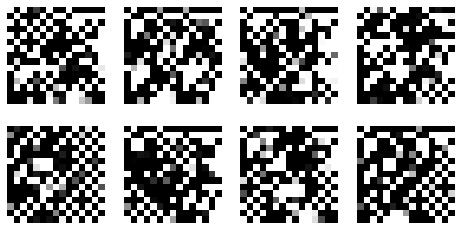

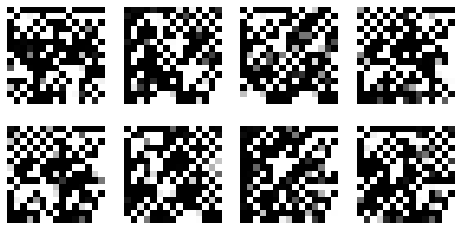

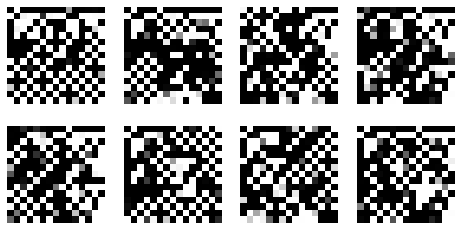

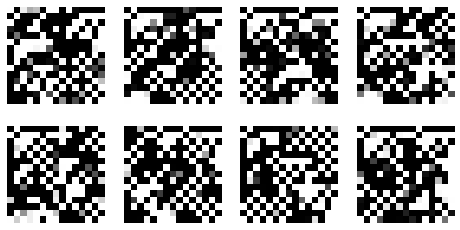

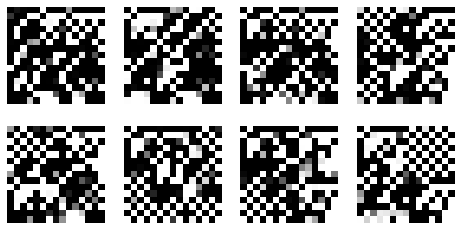

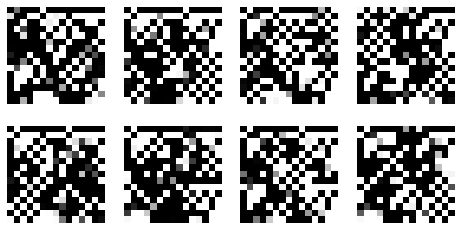

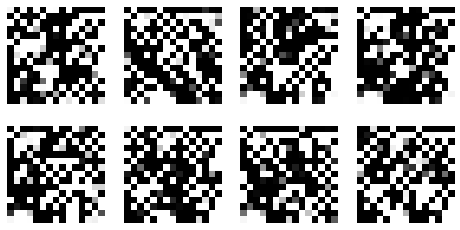

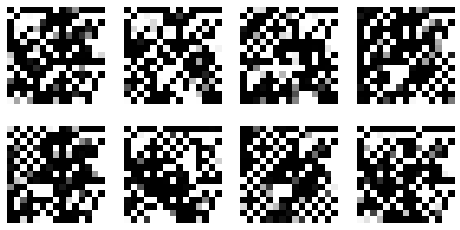

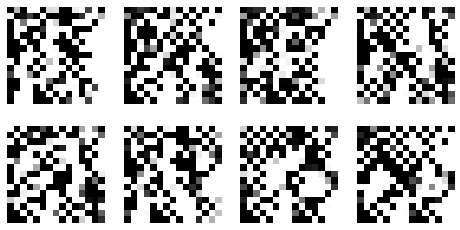

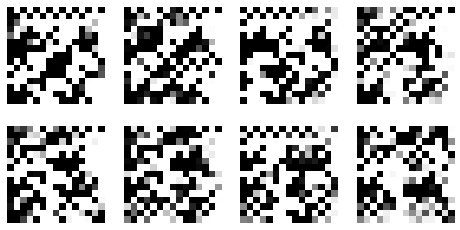

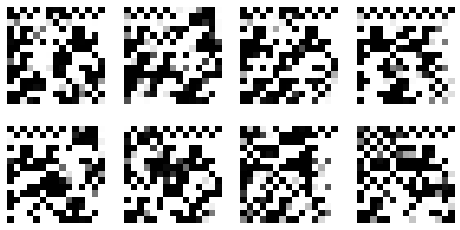

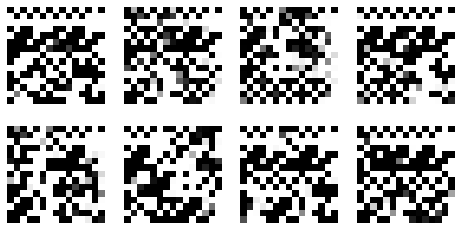

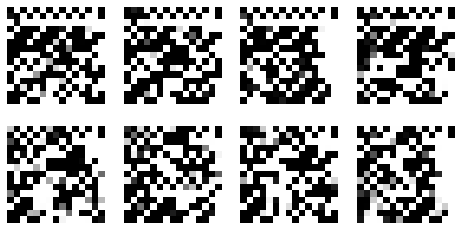

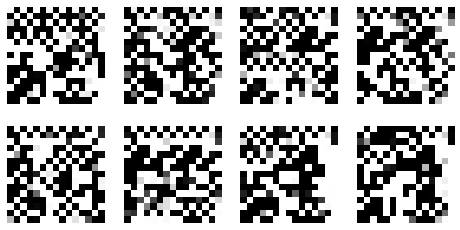

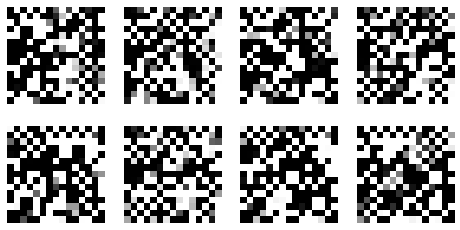

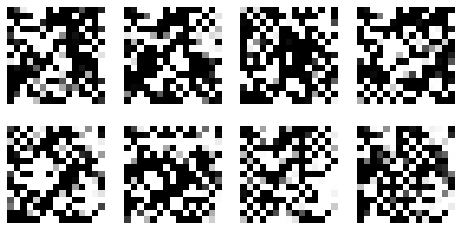

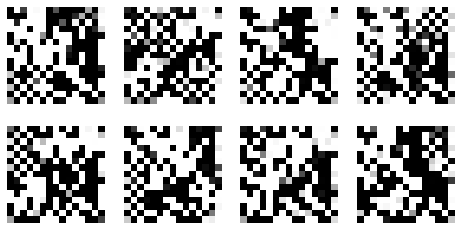

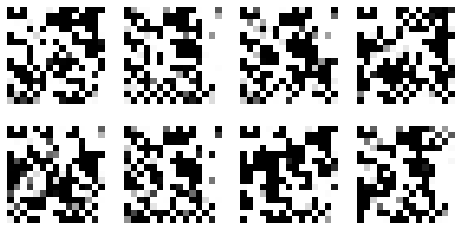

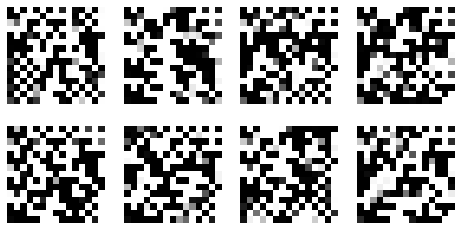

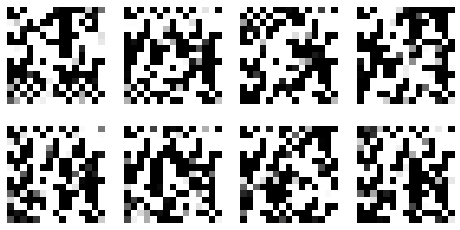

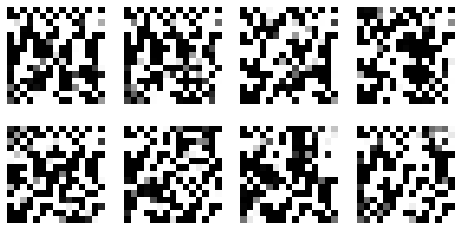

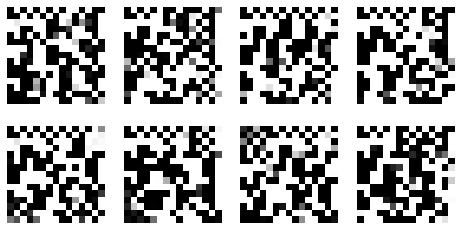

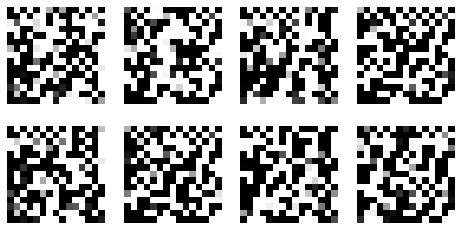

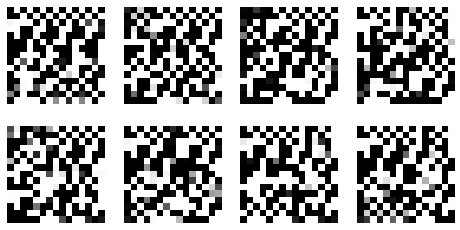

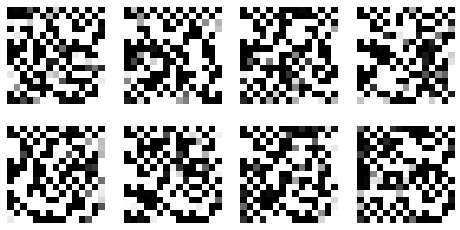

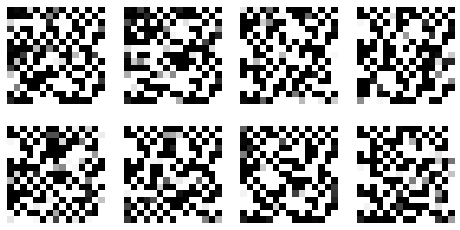

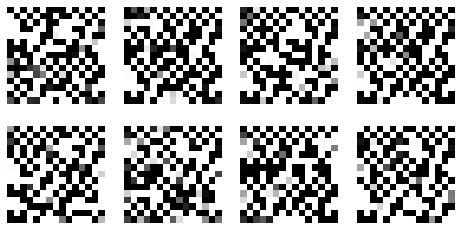

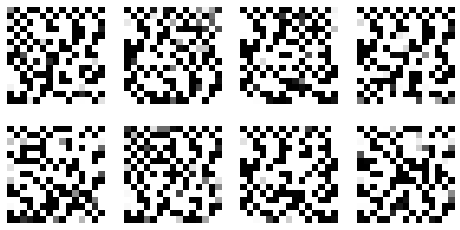

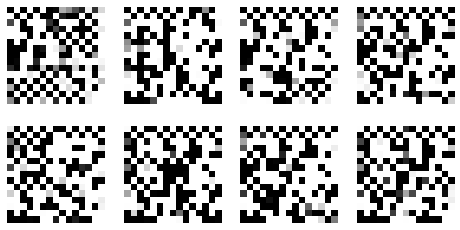

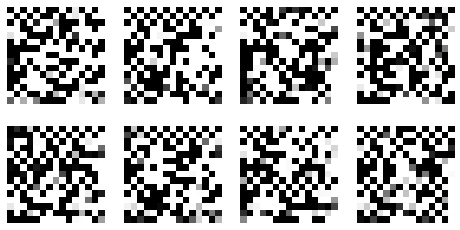

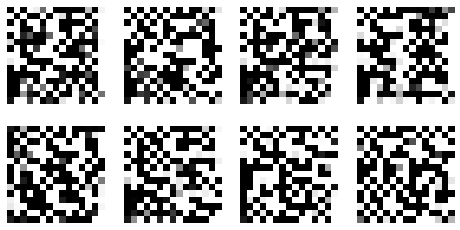

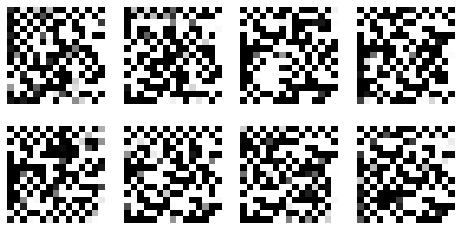

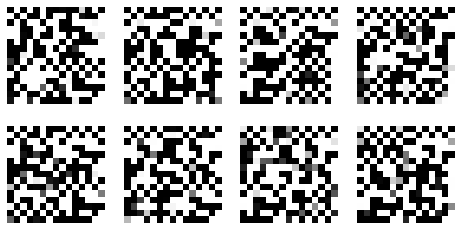

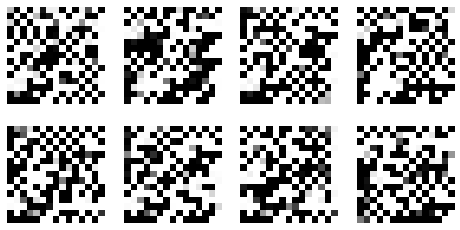

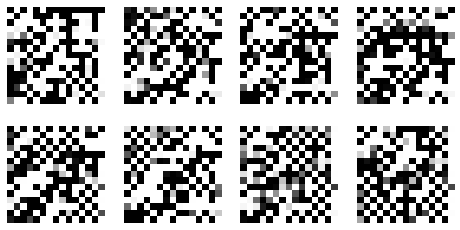

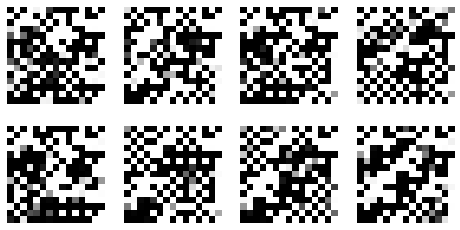

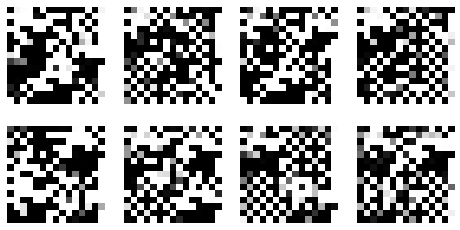

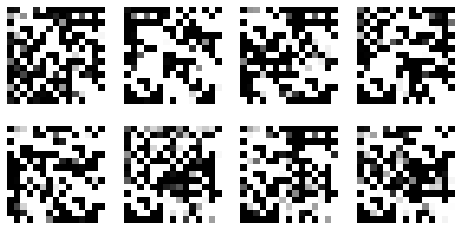

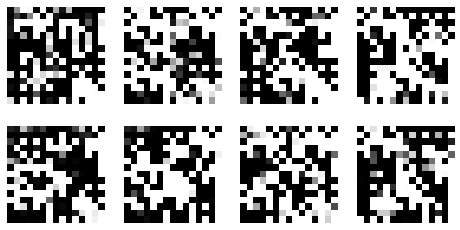

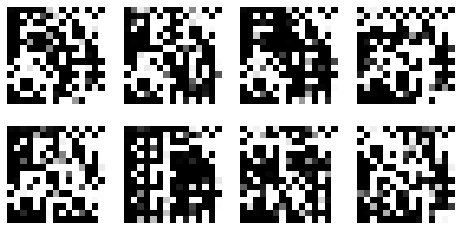

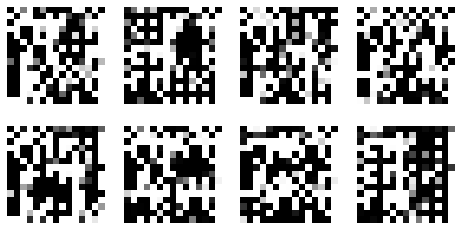

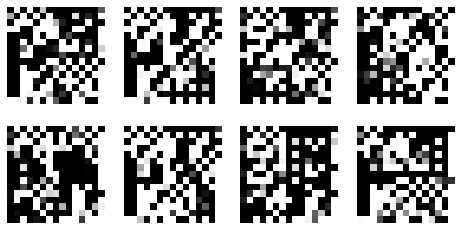

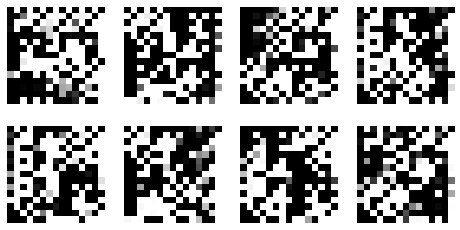

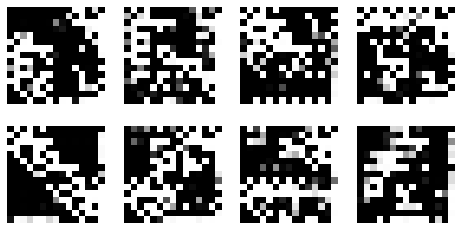

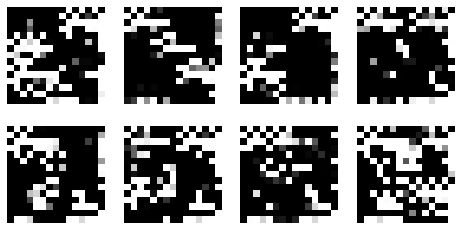

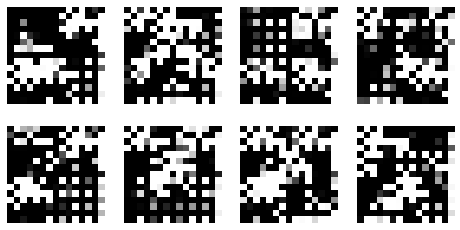

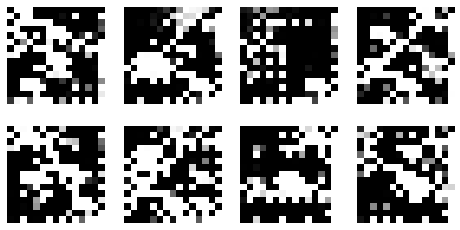

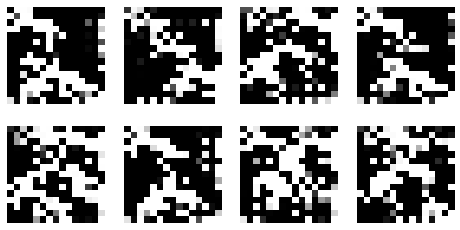

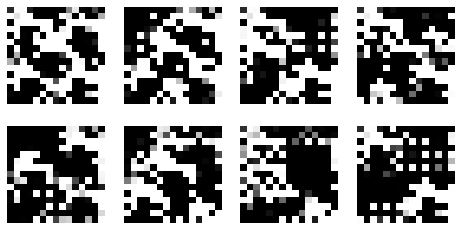

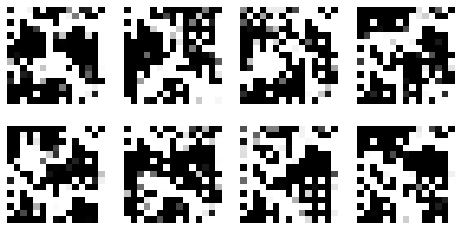

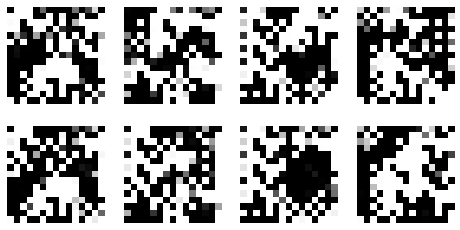

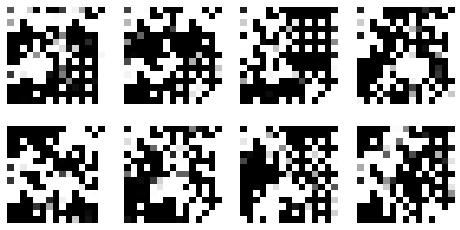

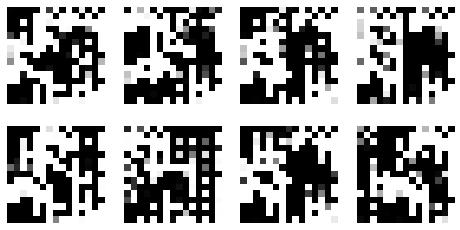

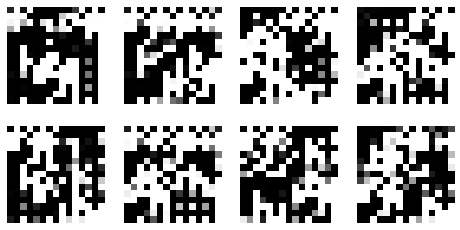

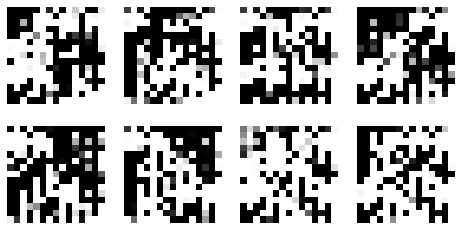

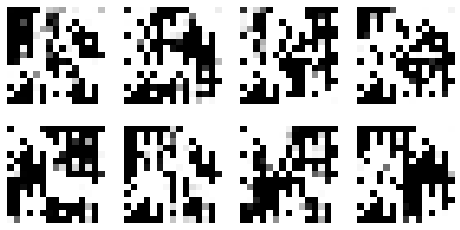

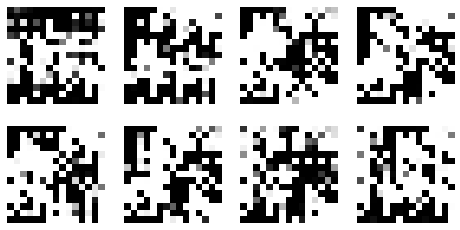

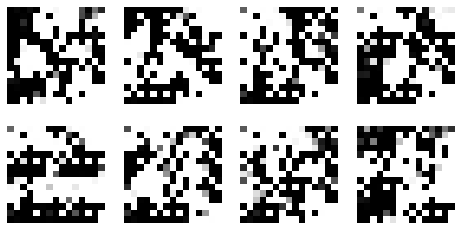

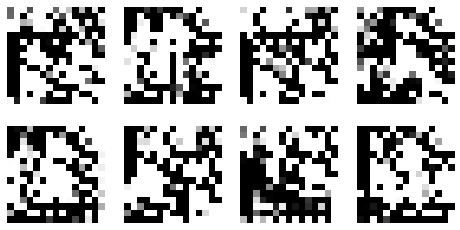

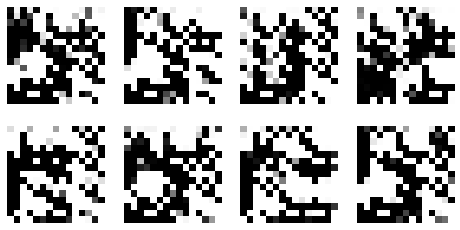

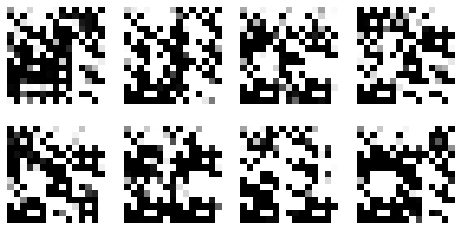

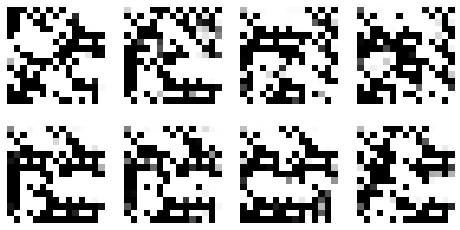

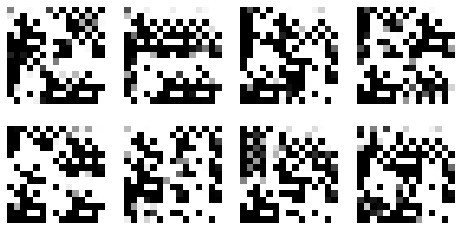

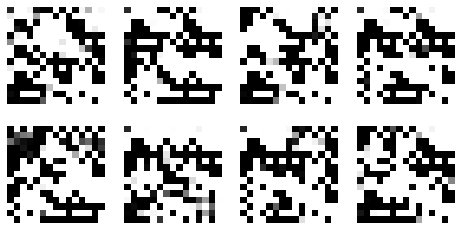

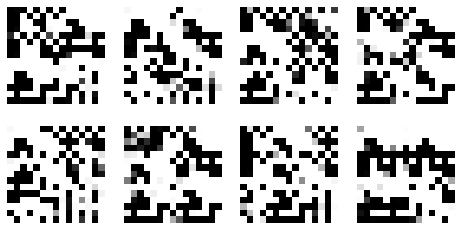

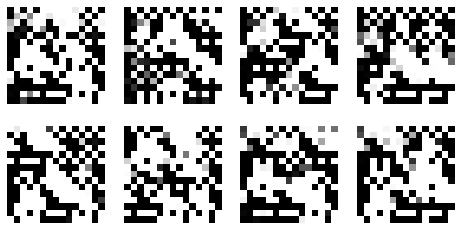

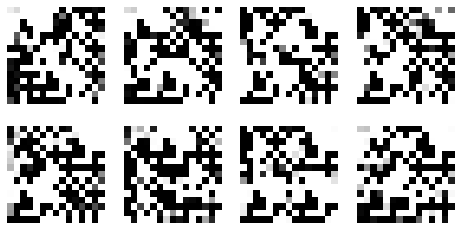

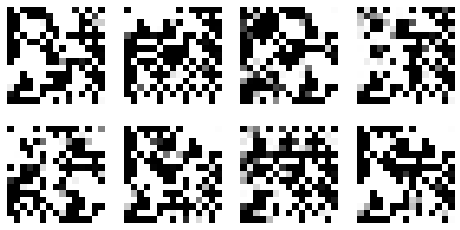

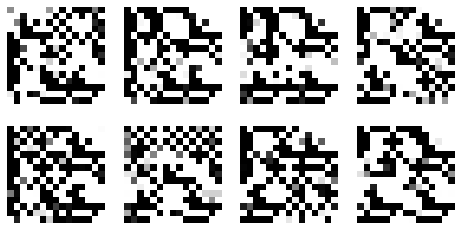

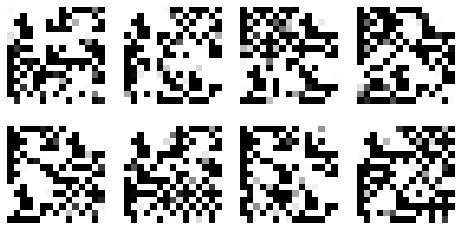

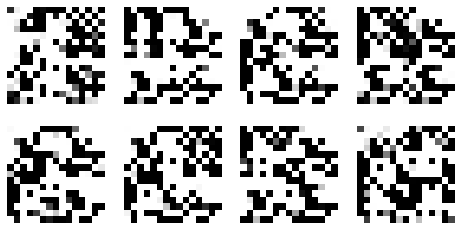

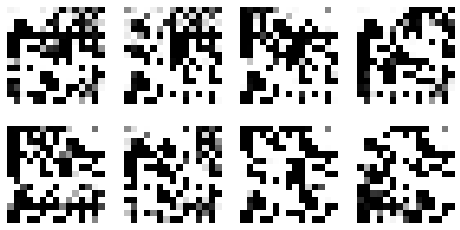

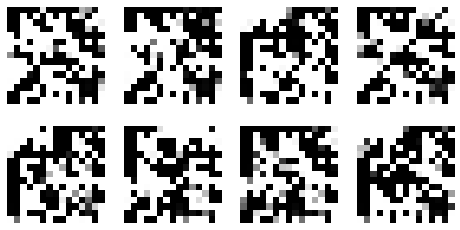

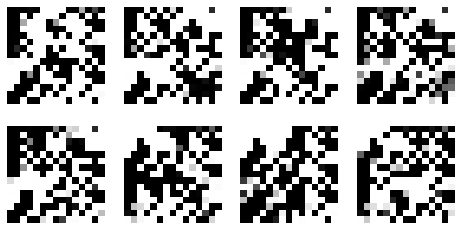

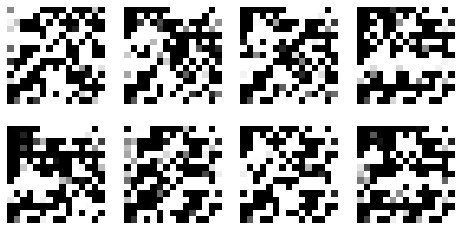

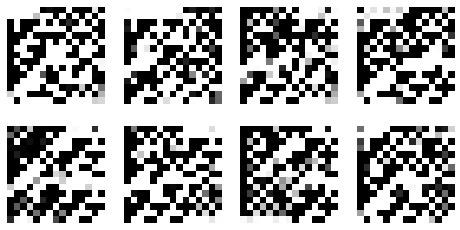

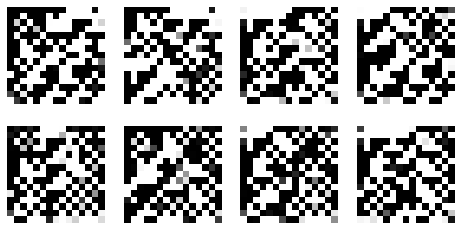

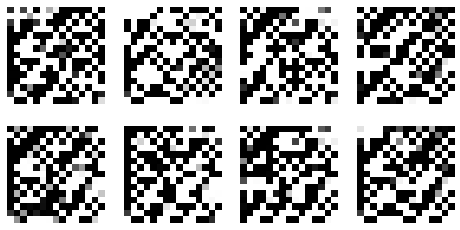

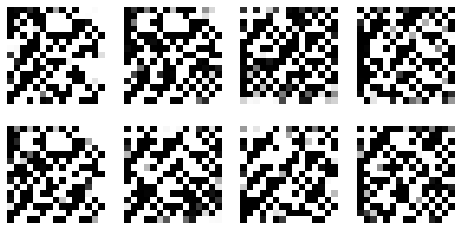

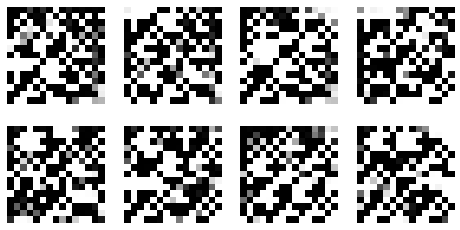

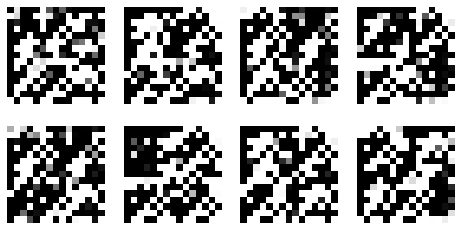

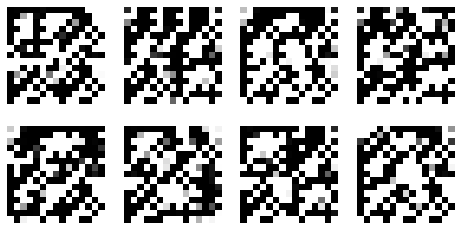

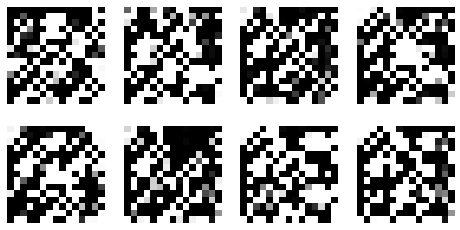

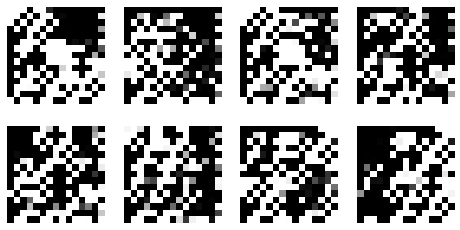

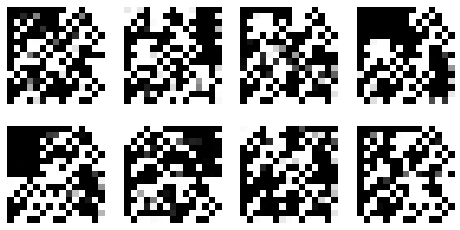

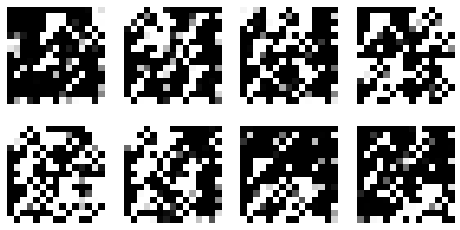

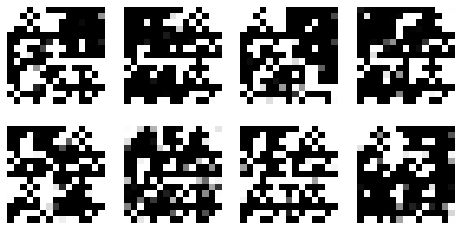

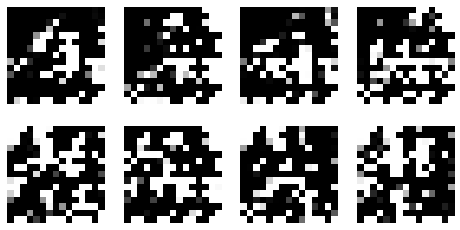

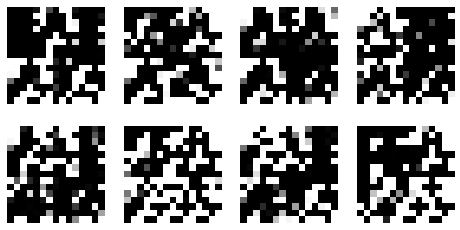

In [347]:
# Set hyperparameters
iterations = 20001
batch_size = 64
sample_interval = 200

# Train the DCGAN for the specified number of iterations
train(target_data, iterations, batch_size, sample_interval)

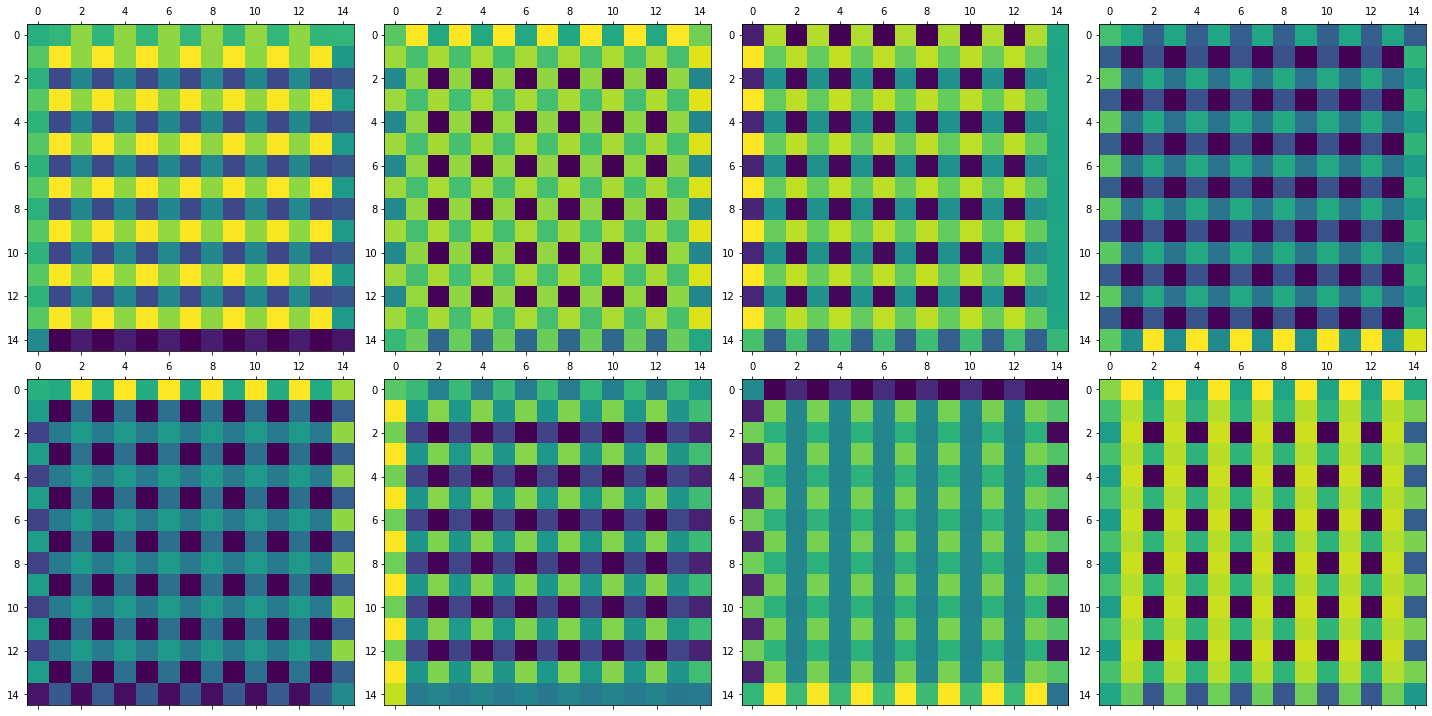

In [348]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = axs.flatten()
for i in range(8):
    axs[i].matshow(generate_pattern('conv2d_43', i)[:,:,0])

fig.tight_layout()

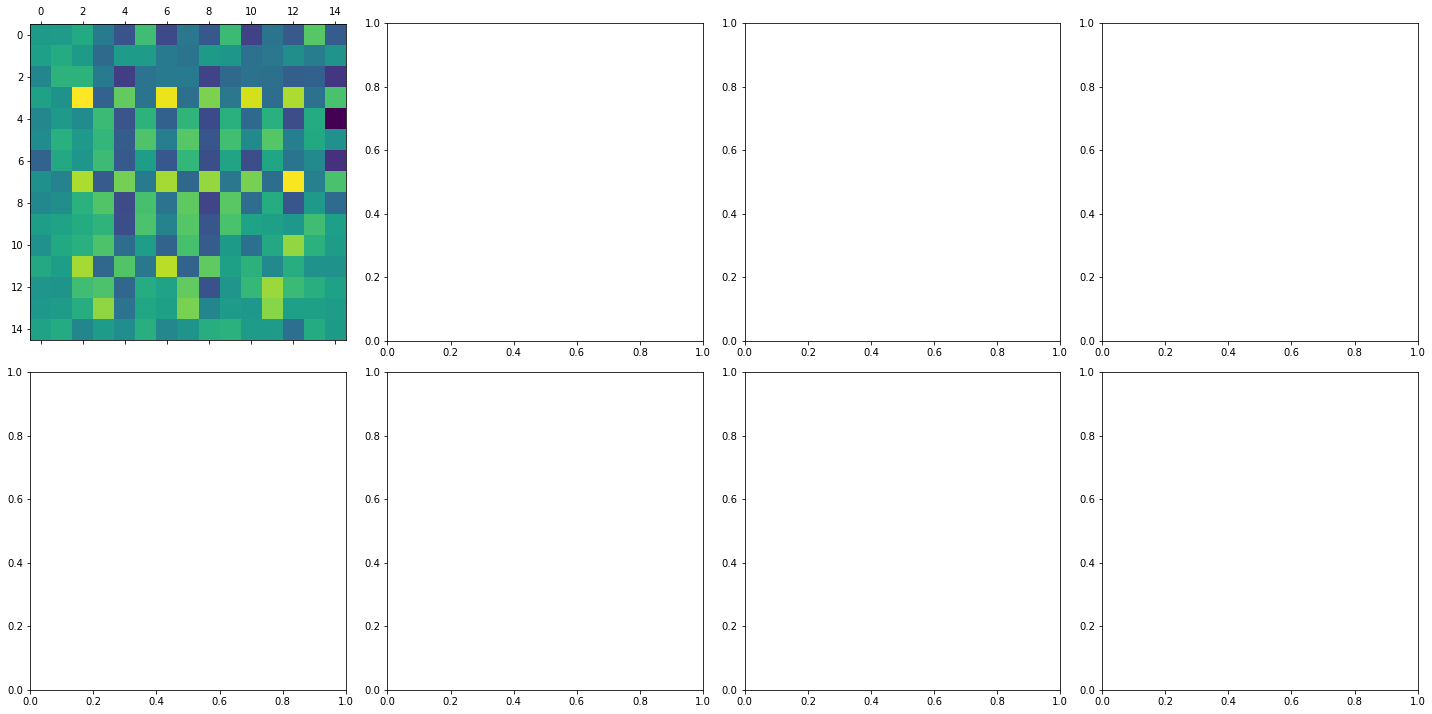

In [358]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
axs = axs.flatten()
for i in range(1):
    axs[i].matshow(generate_pattern('conv2d_44', i, size=15)[:,:,0])

fig.tight_layout()

## Visualize activations

In [375]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 7, 7, 8)           80        
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 3, 3, 1)           73        
_________________________________________________________________
batch_normalization_43 (Batc (None, 3, 3, 1)           4         
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 3, 3, 1)           0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 9)                 0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 10        
Total para

/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [376]:
discriminator.layers

In [379]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in discriminator.layers]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=discriminator.get_input_at(0), outputs=layer_outputs)

In [533]:
img = cfgs['a1'][1000]
img = img[np.newaxis, :, :, np.newaxis]

In [534]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img)

In [535]:
first_layer_activation = activations[4]
print(first_layer_activation.shape)

(1, 3, 3, 1)


In [536]:
# len(activations)
# first_layer_activation#[:, :]

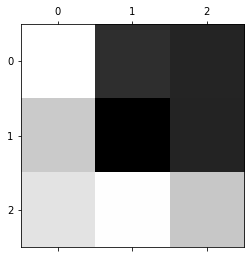

In [537]:
plt.matshow(first_layer_activation[0, :, :, 0], cmap='gray')

In [452]:
first_layer_activation[0, :, :, 0]

array([[2.473751 , 2.4667354, 2.4664547],
       [2.4719522, 2.4651978, 2.4663703],
       [2.4728   , 2.4736967, 2.471873 ]], dtype=float32)

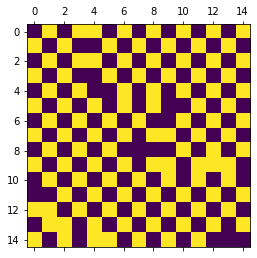

In [435]:
plt.matshow(img[0,:,:,0])